In [1]:
import torch
import torch.nn as nn
import numpy as np
from datasets import Dataset
import matplotlib.pyplot as plt
import matplotlib.patches as pch

In [2]:
rng = np.random.default_rng(seed=2022)
train_size = 100
test_size = 20
#train_size = train_size+test_size

X_0 = {"loc":(1,1), "scale":0.5}
X_1 = {"loc":(-1,-1), "scale":0.75}
eps = {"loc":(0,0), "scale":0.05}

f_transform = np.array([[ -1,  0],
                        [0.5,0.5]])

device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"

In [3]:
#Adatgen függvények

def f_bijection(array_of_points):
    return array_of_points @ f_transform - 2

def gen_features(distribution, size=1, transform=False):
    features = rng.normal(**distribution, size=(size,2))
    if transform:
        return f_bijection(features)
    else:
        return features
    
def prep_data(feature_list, label_list):
    task = np.zeros([0,3])
    for idx, features in enumerate(feature_list):
        #print(features, label_list[idx], np.ones([features.shape[0],1]) * label_list[idx])
        datapoints = np.concatenate(
            [features, 
             np.ones([features.shape[0],1]) * label_list[idx]], 
            axis=1)
        #print(datapoints)
        task = np.concatenate([task, datapoints])
        #print(task)
    rng.shuffle(task)
    return torch.from_numpy(task)

In [4]:
#Adatgenerálás
noise1 = gen_features(eps, train_size)
noise2 = gen_features(eps, train_size)

task1_0 = gen_features(X_0, train_size)
task1_1 = gen_features(X_1, train_size)
Task1 = prep_data([task1_0, task1_1], [0, 1]).to(device)

taskA_0 = gen_features(X_0, train_size, transform=True) + noise1
taskA_1 = gen_features(X_1, train_size, transform=True) + noise2
TaskA = prep_data([taskA_0, taskA_1], [2, 3]).to(device)

taskB_0 = gen_features(X_0, train_size, transform=True) + 10*noise1
taskB_1 = gen_features(X_1, train_size, transform=True) + 10*noise2
TaskB = prep_data([taskB_0, taskB_1], [2, 3]).to(device)

#Tesztadat generálás
noise1_t = noise1 = gen_features(eps, test_size)
noise2_t = noise1 = gen_features(eps, test_size)

test1_0 = gen_features(X_0, test_size)
test1_1 = gen_features(X_1, test_size)
Test1 = prep_data([test1_0, test1_1], [0, 1]).to(device)

testA_0 = gen_features(X_0, test_size, transform=True) + noise1_t
testA_1 = gen_features(X_1, test_size, transform=True) + noise2_t
TestA = prep_data([testA_0, testA_1], [2, 3]).to(device)

testB_0 = gen_features(X_0, test_size, transform=True) + 10*noise1_t
testB_1 = gen_features(X_1, test_size, transform=True) + 10*noise2_t
TestB = prep_data([testA_0, testA_1], [2, 3]).to(device)

TestA_full = prep_data([test1_0, test1_1, testA_0, testA_1], [0, 1, 2, 3]).to(device)
TestB_full = prep_data([test1_0, test1_1, testB_0, testB_1], [0, 1, 2, 3]).to(device)

In [5]:
class MockupNetwork(nn.Module):
    def __init__(self, num_classes):
        super(MockupNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
        )
        self.softmax = nn.Softmax(dim=0) #nem biztos hogy ez a jó dim de így legalább nem kapok warningot + úgyse használom

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        probs = self.softmax(logits)
        return logits

In [6]:
def train(data, model, loss_fn, optimizer):
    model.train()
    num_datapoints = data.shape[0]
    for i in range(num_datapoints):
        X, y = data[i,:-1], data[i,-1]
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y.long())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if i % 10 == 0:
        #    loss, current = loss.item(), i * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(data, model, loss_fn, corr_list=None, loss_list=None):
    num_datapoints = data.shape[0]
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for i in range(num_datapoints):
            X, y = data[i,:-1], data[i,-1]
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax() == y).item()
    test_loss /= num_datapoints
    
    if loss_list != None: loss_list.append(test_loss)
    if corr_list != None: corr_list.append(correct)
    return test_loss, correct

In [8]:
model = MockupNetwork(4).to(device).double()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

num_epochs = 20
losses, corrects = [], []
loss1, corr1 = [], []
lossA, corrA = [], []

In [9]:
for epoch in range(num_epochs):
    #print(" epoch {}".format(epoch))
    train(Task1, model, loss_fn, optimizer)
    
    test(TestA_full, model, loss_fn, loss_list=losses, corr_list=corrects)
    test(Test1, model, loss_fn, loss_list=loss1, corr_list=corr1)
    test(TestA, model, loss_fn, loss_list=lossA, corr_list=corrA)

for epoch in range(num_epochs):
    #print(" epoch {}".format(epoch))
    train(TaskA, model, loss_fn, optimizer)
    
    test(TestA_full, model, loss_fn, loss_list=losses, corr_list=corrects)
    test(Test1, model, loss_fn, loss_list=loss1, corr_list=corr1)
    test(TestA, model, loss_fn, loss_list=lossA, corr_list=corrA)

In [10]:
def plot_single(plot_list, legend, opts="r", size=(16,6), filename=None):
    plt.figure(figsize=size)
    
    plt.plot(plot_list, opts)
    
    info = pch.Patch(color=opts[0], label=legend) #color=opts[0] kicsit sufnis
    plt.legend(handles=[info], loc="upper left")
    
    if filename != None:
        plt.savefig(filename)
    plt.show()
    
def plot_multi(plots, lgd_list, opt_list, size=(16,6), filename=None):
    plt.figure(figsize=size)
    info_list = []
    
    for idx, plot_list in enumerate(plots):
        plt.plot(plot_list, opt_list[idx])
        
        info = pch.Patch(color=opt_list[idx][0], label=lgd_list[idx]) #color=opt_list[idx][0] kicsit sufnis
        info_list.append(info)
    plt.legend(handles=info_list, loc="upper left")
    
    if filename != None:
        plt.savefig(filename)
    plt.show()

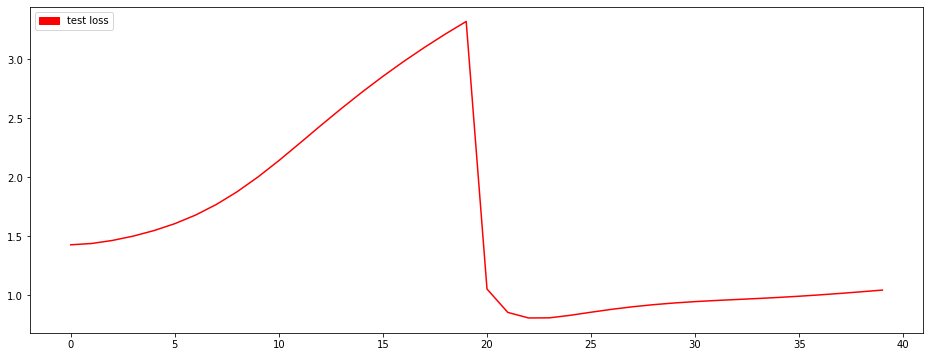

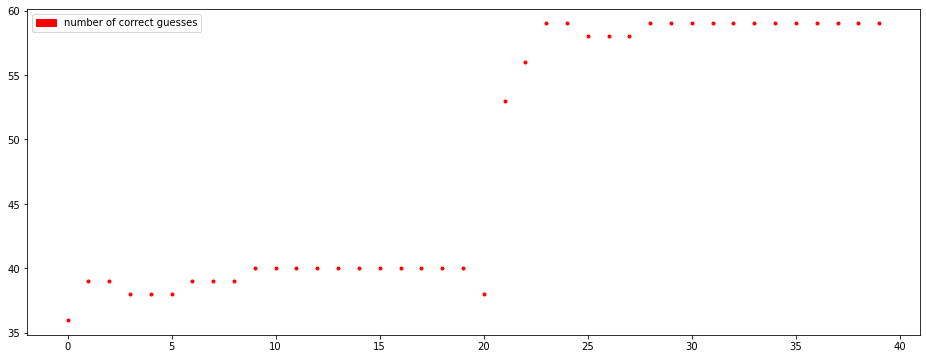

In [11]:
plot_single(losses, "test loss")
plot_single(corrects, "number of correct guesses", opts="r.")

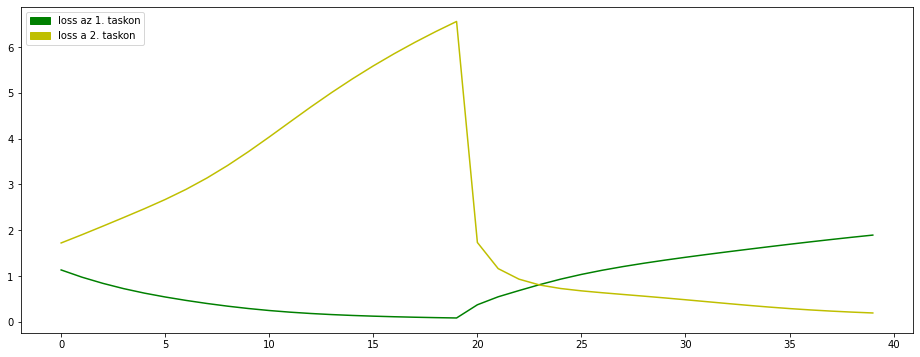

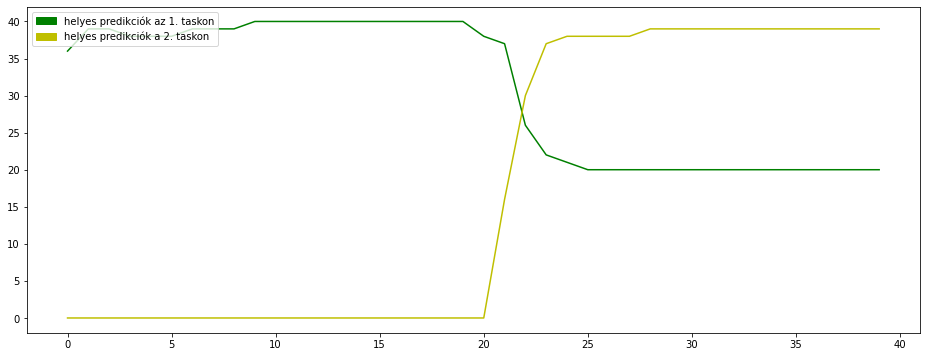

In [12]:
plot_multi([loss1, lossA], 
           ["loss az 1. taskon", "loss a 2. taskon"], 
           ["g", "y"])
plot_multi([corr1, corrA], 
           ["helyes predikciók az 1. taskon", "helyes predikciók a 2. taskon"], 
           ["g", "y"])

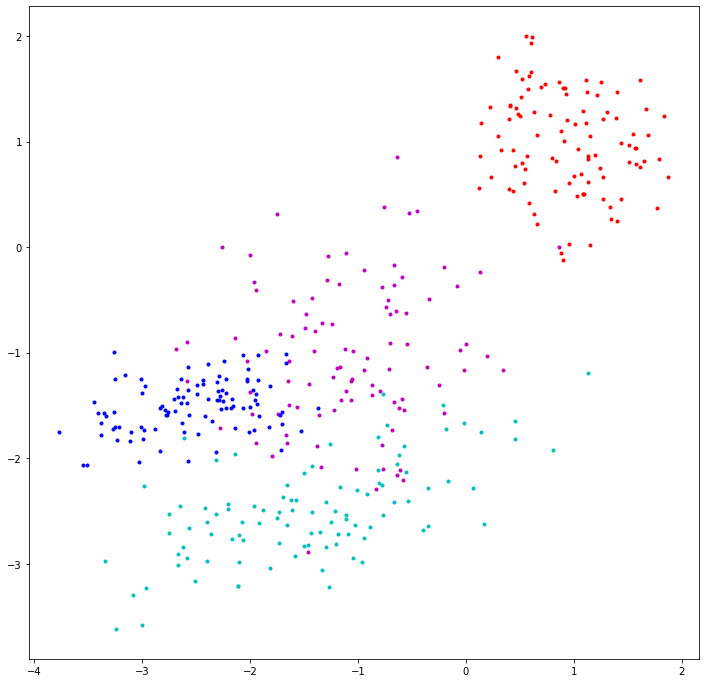

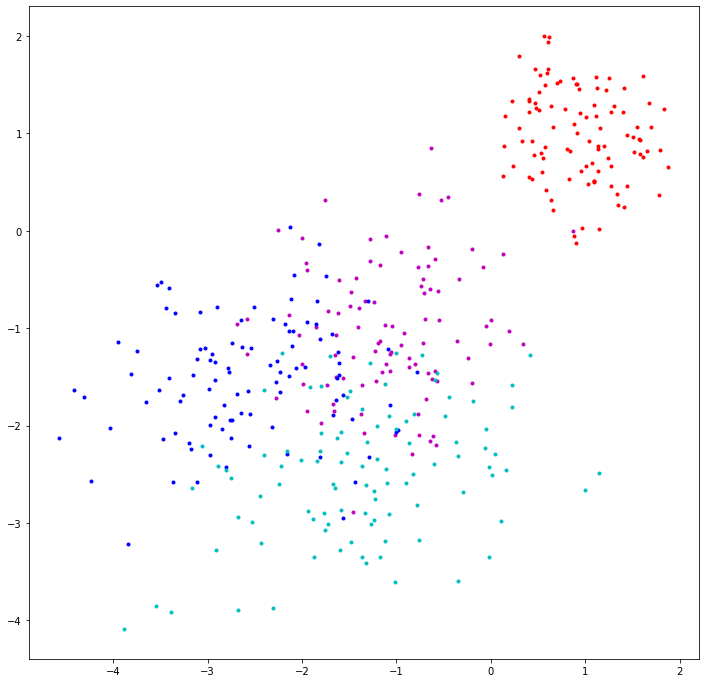

In [13]:
#Adathalmazok ábrázolva
plt.figure(figsize=(12,12))
plt.plot(task1_0[:,0], task1_0[:,1], "r.")
plt.plot(task1_1[:,0], task1_1[:,1], "m.")

plt.plot(taskA_0[:,0], taskA_0[:,1], "b.")
plt.plot(taskA_1[:,0], taskA_1[:,1], "c.")
plt.show()

plt.figure(figsize=(12,12))
plt.plot(task1_0[:,0], task1_0[:,1], "r.")
plt.plot(task1_1[:,0], task1_1[:,1], "m.")

plt.plot(taskB_0[:,0], taskB_0[:,1], "b.")
plt.plot(taskB_1[:,0], taskB_1[:,1], "c.")
plt.show()